In [1]:
import numpy as np
import pandas as pd
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords
from gensim import corpora
from collections import defaultdict
import pprint
import re
from gensim import models
from scipy.sparse import lil_matrix, hstack, csr_matrix, vstack
import gensim.downloader as api
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Data Preprocessing
In this section, we preprocess the data and transform raw text data to matrix form. Then, all data is divided into training set and test set. After that, a dictionary is built upon training set.

In [9]:
def specific_preprocess(doc):
    return simple_preprocess(doc,min_len=2)

def remove_specific_words(s):
    s = re.sub(r"\bLyrics"," ",s)
    s = re.sub(r"\[.+\]"," ",s)
    s = re.sub(r"\b\d+\b Contributors"," ",s)
    s = re.sub(r"Embed"," ",s)
    s = re.sub(r"You might also like"," ",s)
    return s

def count_space(s):
    return s.count(' ')

def remove_short_words(s):
    s = re.sub(r"\b..\b"," ",s)
    s = re.sub(r"\b . \b"," ",s)
    pronoun = [r"\b you\b",r"\b yours\b",r"\b him \b",r"\b his\b", r"\b she \b", r"\b her \b", r"\b hers\b",
               r"\b they \b", r"\b them \b", r"\b their \b", r"\b theirs \b",r"\b You\b",r"\b Yours\b",
               r"\b Him \b",r"\b His\b", r"\b She \b", r"\b Her \b", r"\b Hers\b",
               r"\b They \b", r"\b Them \b", r"\b Their \b", r"\b Theirs \b"]
    conj = [r"\b and \b", r"\b then \b",r"\b for\b", r"\b from\b", r"\b with\b",
            r"\b about\b",r"\b And \b", r"\b Then \b",r"\b For\b", r"\b From\b", r"\b With\b",
            r"\b About\b"]
    for word in pronoun:
        s = re.sub(word," ",s)
    for word in conj:
        s = re.sub(word," ",s)
    return s

def count_lines(s):
    res = len(re.findall(r"\r\n",s))
    return res

def count_paras(s):
    res = len(re.findall(r"\r\n\r\n",s))
    return res

df = pd.read_csv("data/billboard_lyrics_genres.csv")
df_activeyear = pd.read_csv("data/first_active_years.csv")
df_activeyear = df_activeyear.drop_duplicates(subset=["band_singer","title","year"],ignore_index=True)
df["active_years"] = 0

for i in range(df.shape[0]):
    ay_tmp = df_activeyear.loc[(df_activeyear["band_singer"]==df.loc[i,"band_singer"])&(df_activeyear["title"]==df.loc[i,"title"])&(df_activeyear["year"]==df.loc[i,"year"])].active_years
    if not ay_tmp.empty:
        df.loc[i,"active_years"] = int(ay_tmp)

df_tmp = df.loc[df["active_years"]!=0].reset_index(drop=True)

df["numword"] = df["lyrics"].map(count_space)
df["num_lines"] = df["lyrics"].map(count_lines)+1
df["num_paras"] = df["lyrics"].map(count_paras)+1
df["av_word_line"] = df["numword"]/df["num_lines"]
df["av_word_paras"] = df["numword"]/df["num_paras"]
df["lyrics"] = df["lyrics"].map(remove_specific_words)
df["lyrics"] = df["lyrics"].map(remove_stopwords)
# df["lyrics"] = df["lyrics"].map(remove_short_words)
# df.to_csv("data/df_cluster.csv")
df["newlyrics"] = df["lyrics"].map(specific_preprocess)

C:\Users\xuzhi\AppData\Local\Temp\ipykernel_19160\2434171206.py:47: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  df.loc[i,"active_years"] = int(ay_tmp)


In [5]:
def find_unique_word(L):
    unique_words = []
    for word in L:
        if word not in unique_words:
            unique_words.append(word)
    return len(unique_words)

df["unique_words"] = df["lyrics"].map(find_unique_word)

Then delete the songs that are not English

In [10]:
def isEnglish(w):
    return w.encode("utf-8").isalpha()

def isListEnglish(L):
    return all(map(isEnglish,L))

df["isEnglish"] = df["newlyrics"].map(isListEnglish)
df = df.loc[df["isEnglish"],:]

In [13]:
df.to_csv("data/df_cluster.csv")

Similarly, perform the same procedure to genre

In [28]:
def remove_pun(s):
    s = re.sub(r"\[\'"," ",s)
    s = re.sub(r"\'\]"," ",s)
    s = re.sub(r"\'"," ",s)
    s = re.sub(r"\[\]"," ",s)
    s = re.sub(r"\,"," ",s)
    s = s.split()
    s = [token.lower() for token in s]
    return s


df["genre"] = df["genre"].map(remove_pun)

In [29]:
freq_gen = defaultdict(int)
for text in df["genre"]:
    for token in text:
        freq_gen[token] += 1

processed_corpus_gen = [[token for token in text if freq_gen[token]>20] for text in df.loc[:,"genre"]]
dict_gen = corpora.Dictionary(processed_corpus_gen)
freq_wanted = {k: v for k,v in freq_gen.items() if v > 100}
pprint.pprint(freq_wanted)

{'alternative': 145,
 'and': 157,
 'country': 416,
 'dance-pop': 155,
 'disco': 148,
 'folk': 141,
 'funk': 170,
 'hard': 102,
 'hip': 435,
 'hop': 376,
 'new': 168,
 'pop': 1383,
 'r&b': 665,
 'rap': 116,
 'rock': 1607,
 'roll': 111,
 'soft': 322,
 'soul': 476,
 'wave': 109}


In this way, we can sort out the genre we want is alternative, country, dance, disco, folk, funk, hip-hop, new wave, pop, r&b, rap, rock, soul (soft stands for soft rock)

In [30]:
gen_des = ["alternative","country","dance","disco","folk","funk","hip","new","pop","r&b","rap","rock","soul"]
gen_des = sorted(gen_des)

# Compute number of columns from maximum word ID in the training data
num_cols = len(gen_des)
dat_gen = lil_matrix((len(df), num_cols), dtype=np.int64)

# Fill in values using apply() and enumerate()
def set_row_func(i, row):
    for word in row["genre"]:
        for k in range(len(gen_des)):
            if re.search(gen_des[k],word):
                dat_gen[i,k] = 1
df[df["genre"].map(len) > 0].reset_index(drop=True).reset_index().apply(lambda row: set_row_func(row["index"], row), axis=1)

# Convert to pandas DataFrame
dat_gen = pd.DataFrame.sparse.from_spmatrix(dat_gen)

Then, we should tag the data for classification.

In [31]:
df["label"] = np.zeros(df.shape[0])

bins = [1970,1980,1990,2000,2010,np.inf]

labels = [0,1,2,3,4,5]

df["label"] = np.where(df["year"] < bins[0], labels[0],
                               np.where(df["year"] < bins[1], labels[1],
                                        np.where(df["year"] < bins[2], labels[2],
                                                 np.where(df["year"] < bins[3], labels[3],
                                                          np.where(df["year"] < bins[4], labels[4], labels[5])))))

Then, data is split to training set and test set.

In [32]:
np.random.seed(515)
idx = np.repeat(range(10),len(df.iloc[:,0])//10+1)
df["idx"] = np.random.choice(idx[range(len(df.iloc[:,0]))],size=len(df.iloc[:,0]))
df_train = df.loc[df["idx"]!=0,:]
df_test = df.loc[df["idx"]==0,:]

Build a dictionary based on training set.

In [33]:
freq = defaultdict(int)
for text in df_train["lyrics"]:
    for token in text:
        freq[token] += 1

processed_corpus = [[token for token in text if freq[token]>20] for text in df_train.loc[:,"lyrics"]]
dictionary = corpora.Dictionary(processed_corpus)
df_train["freq_count"] = [dictionary.doc2bow(text) for text in processed_corpus]

C:\Users\xuzhi\AppData\Local\Temp\ipykernel_13756\4121515207.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["freq_count"] = [dictionary.doc2bow(text) for text in processed_corpus]


In [34]:
# Compute number of columns from maximum word ID in the training data
num_cols = max(dictionary.keys())+1
dat_train = lil_matrix((len(df_train), num_cols), dtype=np.int64)

# Fill in values using apply() and enumerate()
def set_row_func(i, row):
    indices = [count for count, word_id in row["freq_count"]]
    values = [value for _, value in row["freq_count"]]
    dat_train[i, indices] = values
df_train[df_train["freq_count"].map(len) > 0].reset_index(drop=True).reset_index().apply(lambda row: set_row_func(row["index"], row), axis=1)

# Convert to pandas DataFrame
dat_train = pd.DataFrame.sparse.from_spmatrix(dat_train)

Then, perform the same procedure to test set with the dictionary.

In [35]:
df_test = df.loc[df["idx"]==0,:]
processed_corpus = [[token for token in text if freq[token]>20] for text in df_test.loc[:,"lyrics"]]
df_test["freq_count"] = [dictionary.doc2bow(text) for text in processed_corpus]

# Compute number of columns from maximum word ID in the training data
num_cols = max(dictionary.keys())+1
dat_test = lil_matrix((len(df_test), num_cols), dtype=np.int64)

# Fill in values using apply() and enumerate()
def set_row_func(i, row):
    indices = [count for count, word_id in row["freq_count"] if count < num_cols]
    values = [value for count, value in row["freq_count"] if count < num_cols and value!=0]
    dat_test[i, indices] = values
df_test[df_test["freq_count"].map(len) > 0].reset_index(drop=True).reset_index().apply(lambda row: set_row_func(row["index"], row), axis=1)

# Convert to pandas DataFrame
dat_test = pd.DataFrame.sparse.from_spmatrix(dat_test)

C:\Users\xuzhi\AppData\Local\Temp\ipykernel_13756\2217317512.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["freq_count"] = [dictionary.doc2bow(text) for text in processed_corpus]


# Perform TF-IDF

In [36]:
bow_corpus = list(df_train["freq_count"])
tfidf = models.TfidfModel(bow_corpus)
df_train["tfidf"]=tfidf[df_train["lyrics"].map(dictionary.doc2bow)]

C:\Users\xuzhi\AppData\Local\Temp\ipykernel_13756\1318062561.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["tfidf"]=tfidf[df_train["lyrics"].map(dictionary.doc2bow)]


In [37]:
# Compute number of columns from maximum word ID in the training data
num_cols = max(dictionary.keys())+1
dat_tfidf_train = lil_matrix((len(df_train), num_cols), dtype=np.float64)

# Fill in values using apply() and enumerate()
def set_row_func(i, row):
    indices = [count for count, word_id in row["tfidf"]]
    values = [value for _, value in row["tfidf"]]
    dat_tfidf_train[i, indices] = values
df_train[df_train["tfidf"].map(len) > 0].reset_index(drop=True).reset_index().apply(lambda row: set_row_func(row["index"], row), axis=1)

# Convert to pandas DataFrame
dat_tfidf_train = pd.DataFrame.sparse.from_spmatrix(dat_tfidf_train)

In [38]:
df_test["tfidf"]=tfidf[df_test["lyrics"].map(dictionary.doc2bow)]

# Compute number of columns from maximum word ID in the training data
num_cols = max(dictionary.keys())+1
dat_tfidf_test = lil_matrix((len(df_test), num_cols), dtype=np.float64)

# Fill in values using apply() and enumerate()
def set_row_func(i, row):
    indices = [count for count, word_id in row["tfidf"] if count < num_cols]
    values = [value for count, value in row["tfidf"] if count < num_cols and value != 0]
    dat_tfidf_test[i, indices] = values
df_test[df_test["tfidf"].map(len) > 0].reset_index(drop=True).reset_index().apply(lambda row: set_row_func(row["index"], row), axis=1)

# Convert to pandas DataFrame
dat_tfidf_test = pd.DataFrame.sparse.from_spmatrix(dat_tfidf_test)

C:\Users\xuzhi\AppData\Local\Temp\ipykernel_13756\3654324900.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["tfidf"]=tfidf[df_test["lyrics"].map(dictionary.doc2bow)]


# Processed Data
The data processed are diveded into the blow categories:

Original word frequency + genre

TF-IDF word frequency + genre


In [39]:
dat_gen = dat_gen.reset_index()
df = df.reset_index(drop=True)
dat_gen_train = dat_gen.loc[df["idx"]!=0,:].reset_index(drop=True)
dat_gen_test = dat_gen.loc[df["idx"]==0,:].reset_index(drop=True)

In [67]:
train_ones = csr_matrix(np.ones(df_train.shape[0])).transpose()
test_ones = csr_matrix(np.ones(df_test.shape[0])).transpose()
train_label = csr_matrix(df_train.loc[:,"label"]).transpose()
test_label = csr_matrix(df_test.loc[:,"label"]).transpose()
train_activeyear = csr_matrix(df_train.loc[:,"active_years":"unique_words"])
test_activeyear = csr_matrix(df_test.loc[:,"active_years":"unique_words"])

gen_train = csr_matrix(dat_gen_train.loc[:,0:])
lyrics_train = csr_matrix(dat_train.loc[:,0:])
data_train = hstack([train_ones,gen_train, lyrics_train,train_activeyear,train_label])
data_train = pd.DataFrame.sparse.from_spmatrix(data_train)

gen_test = csr_matrix(dat_gen_test.loc[:,0:])
lyrics_test = csr_matrix(dat_test.loc[:,0:])
data_test = hstack([test_ones,gen_test, lyrics_test,test_activeyear,test_label])
data_test = pd.DataFrame.sparse.from_spmatrix(data_test)


lyrics_tfidf_train = csr_matrix(dat_tfidf_train.loc[:,0:])
data_tfidf_train = hstack([train_ones,gen_train,lyrics_tfidf_train,train_activeyear,train_label])
data_tfidf_train = pd.DataFrame.sparse.from_spmatrix(data_tfidf_train)

lyrics_tfidf_test = csr_matrix(dat_tfidf_test.loc[:,0:])
data_tfidf_test = hstack([test_ones,gen_test,lyrics_tfidf_test,test_activeyear,test_label])
data_tfidf_test = pd.DataFrame.sparse.from_spmatrix(data_tfidf_test)

In [68]:
df_tmp = df_train.loc[:,"active_years":"unique_words"]
word_name = [dictionary[i] for i in range(max(dictionary.keys())+1)]
word_name = ['intercept']+gen_des + word_name +list(df_tmp.columns)+ ['label']
data_tfidf_test.columns = word_name
data_tfidf_train.columns = word_name
data_train.columns = word_name
data_test.columns = word_name

In [71]:
# data_tfidf_train.to_csv("data/train_tfidf_data.csv")
# data_tfidf_test.to_csv("data/test_tfidf_data.csv")
# # data_train = hstack([lyrics_train,train_label])
# # data_train = pd.DataFrame.sparse.from_spmatrix(data_train)
# # data_test = hstack([lyrics_test,test_label])
# # data_test = pd.DataFrame.sparse.from_spmatrix(data_test)
# # word_name = [dictionary[i] for i in range(max(dictionary.keys())+1)]
# # word_name = word_name+['label']
# # data_train.columns = word_name
# # data_test.columns = word_name

# data_train.to_csv("data/train_data_all.csv")
# data_test.to_csv("data/test_data_all.csv")
# df_train.to_csv("data/train_other.csv")

# Logistic Regression

In [69]:
from sklearn.linear_model import LogisticRegression

mr = LogisticRegression(penalty='l2',solver="liblinear",max_iter=1000).fit(data_tfidf_train.iloc[:,:(data_tfidf_train.shape[1]-1)],np.array(df_train["label"]))
pred = mr.predict(data_tfidf_test.iloc[:,:(data_tfidf_train.shape[1]-1)])

print(sum(pred == df_test["label"])/len(pred))
print(np.mean((pred-df_test["label"])**2))

0.5472103004291845
1.5665236051502145


In [70]:
mr = LogisticRegression(penalty='l2',solver="liblinear",max_iter=1000).fit(data_tfidf_train.iloc[:,[0,(data_tfidf_train.shape[1]-2)]],np.array(df_train["label"]))
pred = mr.predict(data_tfidf_test.iloc[:,[0,(data_tfidf_train.shape[1]-2)]])

print(sum(pred == df_test["label"])/len(pred))

0.2532188841201717


Compared with $l_1$ penalty, $l_2$ is better.

In [21]:
mr = LogisticRegression(penalty='l1',solver='liblinear',max_iter=100000).fit(data_tfidf_train.iloc[:,:(data_tfidf_train.shape[1]-1)],np.array(df_train["label"]))
pred = mr.predict(data_tfidf_test.iloc[:,:(data_tfidf_train.shape[1]-1)])

print(sum(pred == df_test["label"])/len(pred))
print(np.mean((pred-df_test["label"])**2))

0.5321888412017167
2.2939914163090127


In [22]:
mr = LogisticRegression(penalty='l2',solver="liblinear").fit(data_tfidf_train.iloc[:,:len(gen_des)],np.array(df_train["label"]))
pred = mr.predict(data_tfidf_test.iloc[:,:len(gen_des)])

print(sum(pred == df_test["label"])/len(pred))
print(np.mean((pred-df_test["label"])**2))

0.4592274678111588
3.4377682403433476


In [23]:
mr = LogisticRegression(penalty='l2',solver="liblinear").fit(data_tfidf_train.iloc[:,len(gen_des):(data_tfidf_train.shape[1]-1)],np.array(df_train["label"]))
pred = mr.predict(data_tfidf_test.iloc[:,len(gen_des):(data_tfidf_train.shape[1]-1)])

print(sum(pred == df_test["label"])/len(pred))
print(np.mean((pred-df_test["label"])**2))

0.34763948497854075
3.3240343347639487


In [24]:
mr = LogisticRegression(penalty='l1',solver="liblinear").fit(data_train.iloc[:,:(data_train.shape[1]-1)],np.array(df_train["label"]))
pred = mr.predict(data_test.iloc[:,:(data_train.shape[1]-1)])

print(sum(pred == df_test["label"])/len(pred))
print(np.mean((pred-df_test["label"])**2))

0.43991416309012876
2.0944206008583692


In [45]:
from sklearn.preprocessing import MaxAbsScaler

transformer = MaxAbsScaler()
transformer.fit(data_train.iloc[:,:(data_train.shape[1]-1)])
data_train_scaled = transformer.transform(data_train.iloc[:,:(data_train.shape[1]-1)])
data_test_scaled = transformer.transform(data_test.iloc[:,:(data_train.shape[1]-1)])
data_train_scaled = hstack([data_train_scaled,train_label])
data_test_scaled = hstack([data_test_scaled,test_label])
data_train_scaled = pd.DataFrame.sparse.from_spmatrix(data_train_scaled)
data_test_scaled = pd.DataFrame.sparse.from_spmatrix(data_test_scaled)

In [46]:
mr = LogisticRegression(penalty='l2',solver="liblinear",max_iter=10000).fit(data_train_scaled.iloc[:,:(data_train_scaled.shape[1]-1)],np.array(df_train["label"]))
pred = mr.predict(data_test_scaled.iloc[:,:(data_test_scaled.shape[1]-1)])

print(sum(pred == df_test["label"])/len(pred))
print(np.mean((pred-df_test["label"])**2))

0.5493562231759657
1.7639484978540771


In [72]:
mr_coef_all = mr.coef_
mr_coef_0 = np.argsort(mr_coef_all[0,14:(mr_coef_all.shape[1]-2)])+14
mr_coef_0 = mr_coef_0[::-1]
mr_word_0 = [word_name[mr_coef_0[i]] for i in range(100)]
word_freq_0 = [round(mr_coef_all[0,mr_coef_0[i]]*100) for i in range(100)]
word_freq_0 = {mr_word_0[i]:word_freq_0[i] for i in range(100)}

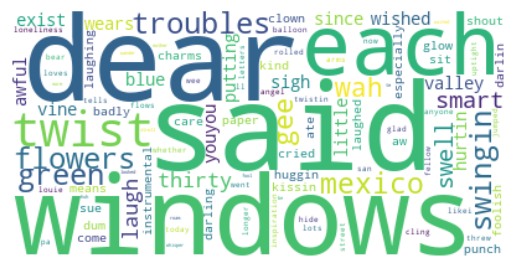

In [73]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud1 = WordCloud(background_color="white")
wordcloud0 = wordcloud1.generate_from_frequencies(word_freq_0)
plt.imshow(wordcloud0,interpolation="bilinear")
plt.axis("off")
plt.show()

Then, it may be better to see the result for 2 logistic regression after some decades apart.

In [50]:
# data preparation
data_train_scaled_60 = data_train_scaled.loc[data_train_scaled.iloc[:,(data_train_scaled.shape[1]-1)]==0,:]
data_train_scaled_70 = data_train_scaled.loc[data_train_scaled.iloc[:,(data_train_scaled.shape[1]-1)]==1,:]
data_train_scaled_80 = data_train_scaled.loc[data_train_scaled.iloc[:,(data_train_scaled.shape[1]-1)]==2,:]
data_train_scaled_90 = data_train_scaled.loc[data_train_scaled.iloc[:,(data_train_scaled.shape[1]-1)]==3,:]
data_train_scaled_00 = data_train_scaled.loc[data_train_scaled.iloc[:,(data_train_scaled.shape[1]-1)]==4,:]
data_train_scaled_10 = data_train_scaled.loc[data_train_scaled.iloc[:,(data_train_scaled.shape[1]-1)]==5,:]

data_test_scaled_60 = data_test_scaled.loc[data_test_scaled.iloc[:,(data_test_scaled.shape[1]-1)]==0,:]
data_test_scaled_70 = data_test_scaled.loc[data_test_scaled.iloc[:,(data_test_scaled.shape[1]-1)]==1,:]
data_test_scaled_80 = data_test_scaled.loc[data_test_scaled.iloc[:,(data_test_scaled.shape[1]-1)]==2,:]
data_test_scaled_90 = data_test_scaled.loc[data_test_scaled.iloc[:,(data_test_scaled.shape[1]-1)]==3,:]
data_test_scaled_00 = data_test_scaled.loc[data_test_scaled.iloc[:,(data_test_scaled.shape[1]-1)]==4,:]
data_test_scaled_10 = data_test_scaled.loc[data_test_scaled.iloc[:,(data_test_scaled.shape[1]-1)]==5,:]

In [51]:
# 60s and 70s
data_train_scaled_67 = pd.concat([data_train_scaled_60,data_train_scaled_70],axis=0)
data_test_scaled_67 = pd.concat([data_test_scaled_60,data_test_scaled_70],axis=0)
mr = LogisticRegression(penalty="l2",solver="liblinear")
mr.fit(data_train_scaled_67.iloc[:,:(data_train_scaled_67.shape[1]-1)],data_train_scaled_67.iloc[:,(data_train_scaled_67.shape[1]-1)])

pred = mr.predict(data_test_scaled_67.iloc[:,:(data_test_scaled_67.shape[1]-1)])
print(sum(pred == data_test_scaled_67.iloc[:,(data_test_scaled_67.shape[1]-1)])/len(pred))

0.608433734939759


In [52]:
# 60s and 80s
data_train_scaled_68 = pd.concat([data_train_scaled_60,data_train_scaled_80],axis=0)
data_test_scaled_68 = pd.concat([data_test_scaled_60,data_test_scaled_80],axis=0)
mr = LogisticRegression(penalty="l2",solver="liblinear")
mr.fit(data_train_scaled_68.iloc[:,:(data_train_scaled_68.shape[1]-1)],data_train_scaled_68.iloc[:,(data_train_scaled_68.shape[1]-1)])

pred = mr.predict(data_test_scaled_68.iloc[:,:(data_test_scaled_68.shape[1]-1)])
print(sum(pred == data_test_scaled_68.iloc[:,(data_test_scaled_68.shape[1]-1)])/len(pred))

0.7466666666666667


In [53]:
# 60s and 90s
data_train_scaled_69 = pd.concat([data_train_scaled_60,data_train_scaled_90],axis=0)
data_test_scaled_69 = pd.concat([data_test_scaled_60,data_test_scaled_90],axis=0)
mr = LogisticRegression(penalty="l2",solver="liblinear")
mr.fit(data_train_scaled_69.iloc[:,:(data_train_scaled_69.shape[1]-1)],data_train_scaled_69.iloc[:,(data_train_scaled_69.shape[1]-1)])

pred = mr.predict(data_test_scaled_69.iloc[:,:(data_test_scaled_69.shape[1]-1)])
print(sum(pred == data_test_scaled_69.iloc[:,(data_test_scaled_69.shape[1]-1)])/len(pred))

0.8742138364779874


In [54]:
# 60s and 00s
data_train_scaled_600 = pd.concat([data_train_scaled_60,data_train_scaled_00],axis=0)
data_test_scaled_600 = pd.concat([data_test_scaled_60,data_test_scaled_00],axis=0)
mr = LogisticRegression(penalty="l2",solver="liblinear")
mr.fit(data_train_scaled_600.iloc[:,:(data_train_scaled_600.shape[1]-1)],data_train_scaled_600.iloc[:,(data_train_scaled_600.shape[1]-1)])

pred = mr.predict(data_test_scaled_600.iloc[:,:(data_test_scaled_600.shape[1]-1)])
print(sum(pred == data_test_scaled_600.iloc[:,(data_test_scaled_600.shape[1]-1)])/len(pred))

0.8993288590604027


In [55]:
# 60s and 10s
data_train_scaled_61 = pd.concat([data_train_scaled_60,data_train_scaled_10],axis=0)
data_test_scaled_61 = pd.concat([data_test_scaled_60,data_test_scaled_10],axis=0)
mr = LogisticRegression(penalty="l2",solver="liblinear")
mr.fit(data_train_scaled_61.iloc[:,:(data_train_scaled_61.shape[1]-1)],data_train_scaled_61.iloc[:,(data_train_scaled_61.shape[1]-1)])

pred = mr.predict(data_test_scaled_61.iloc[:,:(data_test_scaled_61.shape[1]-1)])
print(sum(pred == data_test_scaled_61.iloc[:,(data_test_scaled_61.shape[1]-1)])/len(pred))

0.8855421686746988


In [56]:
# 70s and 80s
data_train_scaled_78 = pd.concat([data_train_scaled_70,data_train_scaled_80],axis=0)
data_test_scaled_78 = pd.concat([data_test_scaled_70,data_test_scaled_80],axis=0)
mr = LogisticRegression(penalty="l2",solver="liblinear")
mr.fit(data_train_scaled_78.iloc[:,:(data_train_scaled_78.shape[1]-1)],data_train_scaled_78.iloc[:,(data_train_scaled_78.shape[1]-1)])

pred = mr.predict(data_test_scaled_78.iloc[:,:(data_test_scaled_78.shape[1]-1)])
print(sum(pred == data_test_scaled_78.iloc[:,(data_test_scaled_78.shape[1]-1)])/len(pred))

0.7402597402597403


In [57]:
# 70s and 90s
data_train_scaled_79 = pd.concat([data_train_scaled_70,data_train_scaled_90],axis=0)
data_test_scaled_79 = pd.concat([data_test_scaled_70,data_test_scaled_90],axis=0)
mr = LogisticRegression(penalty="l2",solver="liblinear")
mr.fit(data_train_scaled_79.iloc[:,:(data_train_scaled_79.shape[1]-1)],data_train_scaled_79.iloc[:,(data_train_scaled_79.shape[1]-1)])

pred = mr.predict(data_test_scaled_79.iloc[:,:(data_test_scaled_79.shape[1]-1)])
print(sum(pred == data_test_scaled_79.iloc[:,(data_test_scaled_79.shape[1]-1)])/len(pred))

0.8773006134969326


In [58]:
# 70s and 00s
data_train_scaled_700 = pd.concat([data_train_scaled_70,data_train_scaled_00],axis=0)
data_test_scaled_700 = pd.concat([data_test_scaled_70,data_test_scaled_00],axis=0)
mr = LogisticRegression(penalty="l2",solver="liblinear")
mr.fit(data_train_scaled_700.iloc[:,:(data_train_scaled_700.shape[1]-1)],data_train_scaled_700.iloc[:,(data_train_scaled_700.shape[1]-1)])

pred = mr.predict(data_test_scaled_700.iloc[:,:(data_test_scaled_700.shape[1]-1)])
print(sum(pred == data_test_scaled_700.iloc[:,(data_test_scaled_700.shape[1]-1)])/len(pred))

0.9084967320261438


In [59]:
# 70s and 10s
data_train_scaled_71 = pd.concat([data_train_scaled_70,data_train_scaled_10],axis=0)
data_test_scaled_71 = pd.concat([data_test_scaled_70,data_test_scaled_10],axis=0)
mr = LogisticRegression(penalty="l2",solver="liblinear")
mr.fit(data_train_scaled_71.iloc[:,:(data_train_scaled_71.shape[1]-1)],data_train_scaled_71.iloc[:,(data_train_scaled_71.shape[1]-1)])

pred = mr.predict(data_test_scaled_71.iloc[:,:(data_test_scaled_71.shape[1]-1)])
print(sum(pred == data_test_scaled_71.iloc[:,(data_test_scaled_71.shape[1]-1)])/len(pred))

0.9


In [60]:
# 80s and 90s
data_train_scaled_89 = pd.concat([data_train_scaled_80,data_train_scaled_90],axis=0)
data_test_scaled_89 = pd.concat([data_test_scaled_80,data_test_scaled_90],axis=0)
mr = LogisticRegression(penalty="l2",solver="liblinear")
mr.fit(data_train_scaled_89.iloc[:,:(data_train_scaled_89.shape[1]-1)],data_train_scaled_89.iloc[:,(data_train_scaled_89.shape[1]-1)])

pred = mr.predict(data_test_scaled_89.iloc[:,:(data_test_scaled_89.shape[1]-1)])
print(sum(pred == data_test_scaled_89.iloc[:,(data_test_scaled_89.shape[1]-1)])/len(pred))

0.8435374149659864


In [61]:
# 80s and 00s
data_train_scaled_800 = pd.concat([data_train_scaled_80,data_train_scaled_00],axis=0)
data_test_scaled_800 = pd.concat([data_test_scaled_80,data_test_scaled_00],axis=0)
mr = LogisticRegression(penalty="l2",solver="liblinear")
mr.fit(data_train_scaled_800.iloc[:,:(data_train_scaled_800.shape[1]-1)],data_train_scaled_800.iloc[:,(data_train_scaled_800.shape[1]-1)])

pred = mr.predict(data_test_scaled_800.iloc[:,:(data_test_scaled_800.shape[1]-1)])
print(sum(pred == data_test_scaled_800.iloc[:,(data_test_scaled_800.shape[1]-1)])/len(pred))

0.8613138686131386


In [62]:
# 80s and 10s
data_train_scaled_81 = pd.concat([data_train_scaled_80,data_train_scaled_10],axis=0)
data_test_scaled_81 = pd.concat([data_test_scaled_80,data_test_scaled_10],axis=0)
mr = LogisticRegression(penalty="l2",solver="liblinear")
mr.fit(data_train_scaled_81.iloc[:,:(data_train_scaled_81.shape[1]-1)],data_train_scaled_81.iloc[:,(data_train_scaled_81.shape[1]-1)])

pred = mr.predict(data_test_scaled_81.iloc[:,:(data_test_scaled_81.shape[1]-1)])
print(sum(pred == data_test_scaled_81.iloc[:,(data_test_scaled_81.shape[1]-1)])/len(pred))

0.8766233766233766


In [63]:
# 90s and 00s
data_train_scaled_900 = pd.concat([data_train_scaled_90,data_train_scaled_00],axis=0)
data_test_scaled_900 = pd.concat([data_test_scaled_90,data_test_scaled_00],axis=0)
mr = LogisticRegression(penalty="l2",solver="liblinear")
mr.fit(data_train_scaled_900.iloc[:,:(data_train_scaled_900.shape[1]-1)],data_train_scaled_900.iloc[:,(data_train_scaled_900.shape[1]-1)])

pred = mr.predict(data_test_scaled_900.iloc[:,:(data_test_scaled_900.shape[1]-1)])
print(sum(pred == data_test_scaled_900.iloc[:,(data_test_scaled_900.shape[1]-1)])/len(pred))

0.7465753424657534


In [64]:
# 90s and 10s
data_train_scaled_91 = pd.concat([data_train_scaled_90,data_train_scaled_10],axis=0)
data_test_scaled_91 = pd.concat([data_test_scaled_90,data_test_scaled_10],axis=0)
mr = LogisticRegression(penalty="l2",solver="liblinear")
mr.fit(data_train_scaled_91.iloc[:,:(data_train_scaled_91.shape[1]-1)],data_train_scaled_91.iloc[:,(data_train_scaled_91.shape[1]-1)])

pred = mr.predict(data_test_scaled_91.iloc[:,:(data_test_scaled_91.shape[1]-1)])
print(sum(pred == data_test_scaled_91.iloc[:,(data_test_scaled_91.shape[1]-1)])/len(pred))

0.8220858895705522


In [65]:
# 00s and 10s
data_train_scaled_01 = pd.concat([data_train_scaled_00,data_train_scaled_10],axis=0)
data_test_scaled_01 = pd.concat([data_test_scaled_00,data_test_scaled_10],axis=0)
mr = LogisticRegression(penalty="l2",solver="liblinear")
mr.fit(data_train_scaled_01.iloc[:,:(data_train_scaled_01.shape[1]-1)],data_train_scaled_01.iloc[:,(data_train_scaled_01.shape[1]-1)])

pred = mr.predict(data_test_scaled_01.iloc[:,:(data_test_scaled_01.shape[1]-1)])
print(sum(pred == data_test_scaled_01.iloc[:,(data_test_scaled_01.shape[1]-1)])/len(pred))

0.7777777777777778


From the above result, it seems that 60s, 70s and 80s are more similar compared with other decades. The following section focuses on combining the three decades

In [47]:
train_label_com = np.zeros((data_train_scaled.shape[0],1))
test_label_com = np.zeros((data_test_scaled.shape[0],1))
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

for i in range(df_train.shape[0]):
    if df_train.loc[i,"label"] <= 2:
        train_label_com[i] = 0
    elif df_train.loc[i,"label"] == 3:
        train_label_com[i] = 1
    elif df_train.loc[i,"label"] == 4:
        train_label_com[i] = 2
    elif df_train.loc[i,"label"] == 5:
        train_label_com[i] = 3

for i in range(df_test.shape[0]):
    if df_test.loc[i,"label"] <= 2:
        test_label_com[i] = 0
    elif df_test.loc[i,"label"] == 3:
        test_label_com[i] = 1
    elif df_test.loc[i,"label"] == 4:
        test_label_com[i] = 2
    elif df_test.loc[i,"label"] == 5:
        test_label_com[i] = 3

train_label_com = train_label_com.reshape((-1,))
test_label_com = test_label_com.reshape((-1,))

In [86]:
from sklearn.model_selection import GridSearchCV

parameters = {'C':1/ np.log(np.linspace(np.exp(1e-3),np.exp(1.5),num=100,dtype=np.float64)),'penalty':["l2"]}
logclf = LogisticRegression(solver="liblinear",max_iter=10000)
clf = GridSearchCV(logclf,param_grid=parameters,
                   n_jobs=6)
clf.fit(data_tfidf_train.iloc[:,:(data_train_scaled.shape[1]-1)],df_train["label"])

GridSearchCV(estimator=LogisticRegression(max_iter=10000, solver='liblinear'),
             n_jobs=6,
             param_grid={'C': array([1.00000000e+03, 2.81526946e+01, 1.45160752e+01, 9.88336540e+00,
       7.54939737e+00, 6.14277720e+00, 5.20205500e+00, 4.52839672e+00,
       4.02203123e+00, 3.62738895e+00, 3.31106392e+00, 3.05176552e+00,
       2.83528242e+00, 2.65176581e+00, 2.49417454e+00, 2.35734107e+00,
       2...
       7.68627211e-01, 7.63039981e-01, 7.57584985e-01, 7.52257350e-01,
       7.47052442e-01, 7.41965852e-01, 7.36993385e-01, 7.32131044e-01,
       7.27375019e-01, 7.22721677e-01, 7.18167553e-01, 7.13709336e-01,
       7.09343865e-01, 7.05068119e-01, 7.00879207e-01, 6.96774365e-01,
       6.92750947e-01, 6.88806418e-01, 6.84938350e-01, 6.81144414e-01,
       6.77422378e-01, 6.73770098e-01, 6.70185520e-01, 6.66666667e-01]),
                         'penalty': ['l2']})

In [98]:
plt.plot(1/ np.log(np.linspace(np.exp(1e-3),np.exp(1.5),num=100,dtype=np.float64)),clf.cv_results_['split4_test_score'])

KeyError: 'split5_test_score'

In [88]:
clf.best_estimator_

LogisticRegression(C=1.2709477322123233, max_iter=10000, solver='liblinear')

In [49]:
mr = LogisticRegression(penalty='l2',solver="liblinear").fit(data_train_scaled.iloc[:,:(data_train_scaled.shape[1]-1)],train_label_com)
pred = mr.predict(data_test_scaled.iloc[:,:(data_test_scaled.shape[1]-1)])

print(sum(pred == test_label_com)/len(pred))

0.7532188841201717


In [118]:
mr_coef_all = mr.coef_
mr_coef_0 = np.argsort(mr_coef_all[0,14:(mr_coef_all.shape[1]-2)])+14
mr_coef_0 = mr_coef_0[::-1]
mr_word_0 = [word_name[mr_coef_0[i]] for i in range(100)]
word_freq_0 = [round(mr_coef_all[0,mr_coef_0[i]]*100) for i in range(100)]
word_freq_0 = {mr_word_0[i]:word_freq_0[i] for i in range(100)}

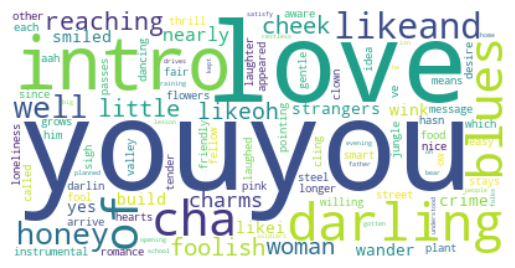

In [119]:
wordcloud1 = WordCloud(background_color="white")
wordcloud0 = wordcloud1.generate_from_frequencies(word_freq_0)
plt.imshow(wordcloud0,interpolation="bilinear")
plt.axis("off")
plt.show()

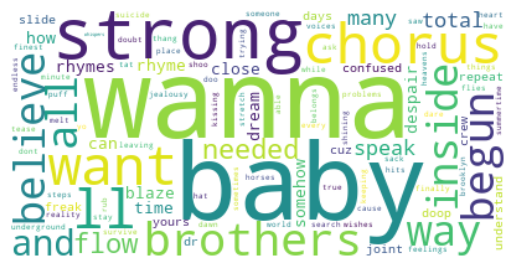

In [120]:
mr_coef_1 = np.argsort(mr_coef_all[1,14:(mr_coef_all.shape[1]-2)])+14
mr_coef_1 = mr_coef_1[::-1]
mr_word_1 = [word_name[mr_coef_1[i]] for i in range(100)]
word_freq_1 = [round(mr_coef_all[1,mr_coef_1[i]]*100) for i in range(100)]
word_freq_1 = {mr_word_1[i]:word_freq_1[i] for i in range(100)}
wordcloud1 = WordCloud(background_color="white")
wordcloud0 = wordcloud1.generate_from_frequencies(word_freq_1)
plt.imshow(wordcloud0,interpolation="bilinear")
plt.axis("off")
plt.show()

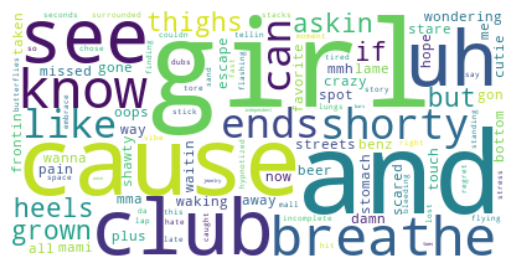

In [122]:
mr_coef_2 = np.argsort(mr_coef_all[2,14:(mr_coef_all.shape[1]-2)])+14
mr_coef_2 = mr_coef_2[::-1]
mr_word_2 = [word_name[mr_coef_2[i]] for i in range(100)]
word_freq_2 = [round(mr_coef_all[2,mr_coef_2[i]]*100) for i in range(100)]
word_freq_2 = {mr_word_2[i]:word_freq_2[i] for i in range(100)}
wordcloud1 = WordCloud(background_color="white")
wordcloud0 = wordcloud1.generate_from_frequencies(word_freq_2)
plt.imshow(wordcloud0,interpolation="bilinear")
plt.axis("off")
plt.show()

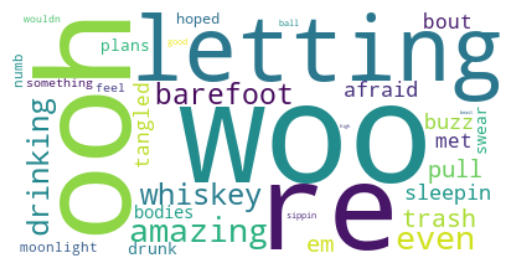

In [129]:
mr_coef_3 = np.argsort(mr_coef_all[3,14:(mr_coef_all.shape[1]-2)])+14
mr_coef_3 = mr_coef_3[::-1]
mr_word_3 = [word_name[mr_coef_3[i]] for i in range(100)]
word_freq_3 = [round(mr_coef_all[3,mr_coef_2[i]]*1000) for i in range(100)]
word_freq_3 = {mr_word_3[i]:word_freq_3[i] for i in range(100)}
wordcloud1 = WordCloud(background_color="white")
wordcloud0 = wordcloud1.generate_from_frequencies(word_freq_3)
plt.imshow(wordcloud0,interpolation="bilinear")
plt.axis("off")
plt.show()

In [45]:
df_train["label"] = np.zeros(df_train.shape[0])
bins = [1990,np.inf]
labels = [0,1]
df_train["label"] = np.where(df_train["year"] < bins[0], labels[0],labels[1])

df_test["label"] = np.zeros(df_test.shape[0])
df_test["label"] = np.where(df_test["year"] < bins[0], labels[0],labels[1])

In [46]:
mr = LogisticRegression(penalty='l2',dual=True,solver="liblinear").fit(data_tfidf_train.iloc[:,:len(gen_des)],df_train["label"])
pred = mr.predict(data_tfidf_test.iloc[:,:len(gen_des)])

print(sum(pred == df_test["label"])/len(pred))

0.7939914163090128


In [47]:
from sklearn.model_selection import GridSearchCV

parameters = {'C':1/ np.log(np.linspace(np.exp(1e-3),np.exp(1.5),num=100,dtype=np.float64))}
logclf = LogisticRegression(penalty="l2",dual=True,solver="liblinear")
clf = GridSearchCV(logclf,param_grid=parameters,
                   scoring='f1',n_jobs=4)
clf.fit(data_tfidf_train.iloc[:,:(data_train.shape[1]-1)],df_train["label"])

KeyboardInterrupt: 

In [ ]:
pprint.pprint(clf.cv_results_)

{'mean_fit_time': array([1.41180372, 1.2727303 , 1.22065654, 1.2714325 , 1.52368474,
       1.51715236, 1.40956945, 1.49648304, 1.52737727, 1.57335234,
       1.53335724, 1.57915368, 1.546942  , 1.76027193, 1.56390519,
       1.60132275, 1.70574627, 1.46470299, 1.60676522, 1.40437431,
       1.4265183 , 1.38369999, 1.41751981, 1.39101629, 1.49465404,
       1.48332739, 1.45793247, 1.3847281 , 1.53913317, 1.46287117,
       1.45350394, 1.49493423, 1.37179093, 1.56450915, 1.50234694,
       1.48528709, 1.75690951, 1.62265148, 1.50505385, 1.58115115,
       1.46761723, 1.55904469, 1.59301558, 1.59314494, 1.63218269,
       1.47640834, 1.55742393, 1.50661755, 1.64142399, 1.4678205 ,
       1.51535621, 1.55767283, 1.44833984, 1.52841578, 1.4756609 ,
       1.40899334, 1.53922544, 1.55364232, 1.60864391, 1.57363257,
       1.65725241, 1.52789621, 1.48743582, 1.65867229, 1.48501925,
       1.5037323 , 1.4991365 , 1.47330127, 1.54285359, 1.4818615 ,
       1.53757129, 1.57600589, 1.67857423, 1

In [ ]:
logclf = LogisticRegression(dual=True,penalty="l2",solver="liblinear")
logclf.fit(np.array(data_tfidf_train.iloc[:,:(data_train.shape[1]-1)]),df_train["label"])
pred = logclf.predict(np.array(data_tfidf_test.iloc[:,:(data_test.shape[1]-1)]))

print(sum(pred == df_test["label"])/len(pred))
print("PPV",sum(pred[df_test["label"]==1]==1)/len(pred[df_test["label"]==1]))
print("PRECISION",sum(df_test.loc[pred==1,"label"]==1)/len(df_test.loc[pred==1,"label"]))

0.3240343347639485
PPV 0.6470588235294118
PRECISION 0.32934131736526945


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Changing to generation
Frequency may have some concerns

In [ ]:
logclf = LogisticRegression(dual=True,penalty="l2",solver="liblinear")
logclf.fit(data_tfidf_train.iloc[:,len(gen_des):(data_train.shape[1]-1)],data_train.iloc[:,11])
pred = logclf.predict(data_tfidf_test.iloc[:,len(gen_des):(data_test.shape[1]-1)])

print(sum(pred == data_test.iloc[:,1])/len(pred))
print("PPV",sum(pred[data_test.iloc[:,11]==1]==1)/len(pred[data_test.iloc[:,11]==1]))
# print("PRECISION",sum(data_test.loc[pred==1,8]==1)/len(data_test.loc[pred==1,8]))

0.8841201716738197
PPV 0.022727272727272728


In [ ]:
np.sum(data_tfidf_train.iloc[:,0])

137.0

In [ ]:
pprint.pprint(np.sum(data_train.iloc[:,0:13],axis=0))

a                   3739
ago                  161
along                 90
and                14657
balls                 65
battle                44
begin                140
bloody                30
catch                415
caught               286
come                5664
comin                418
contributorsthe      148
dtype: int64


# Lemmatize and Bigram
Perform Lemmatize and bigram to lyrics and perform logistic regression

In [19]:
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases

lemmatizer = WordNetLemmatizer()
def lemmatize(L):
    res = list(map(lemmatizer.lemmatize,L))
    return res
df["lyrics"]=df["lyrics"].map(lemmatize)

In [20]:
docs = list(df["lyrics"])
bigram = Phrases(docs,min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            docs[idx].append(token)

In [21]:
from gensim.corpora import Dictionary
dict_lda = Dictionary(docs)
# dict_lda.filter_extremes(no_below=20,no_above=.5)
dict_lda.filter_extremes(no_below=20)

corpus = [dict_lda.doc2bow(doc) for doc in docs]

In [ ]:
print('Number of unique tokens: %d' % len(dict_lda))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2647
Number of documents: 5125


In [ ]:
from gensim.models import LdaModel

num_topics = 6
chunksize = 2000
passes = 20
iterations = 400
eval_every = None

temp = dict_lda[0]
id2word = dict_lda.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [ ]:
top_topics = model.top_topics(corpus)

pprint.pprint(top_topics)

[([(0.043545738, 'baby'),
   (0.021009253, 'wanna'),
   (0.020973725, 're'),
   (0.02092797, 'let'),
   (0.020784214, 'want'),
   (0.019088667, 'me'),
   (0.018708907, 'na'),
   (0.018598603, 'yeah'),
   (0.017913174, 'la'),
   (0.01680424, 'can'),
   (0.015512069, 'll'),
   (0.014038772, 'need'),
   (0.013448951, 'feel'),
   (0.0133223, 'come'),
   (0.012836097, 'gonna'),
   (0.012423523, 'cause'),
   (0.012337268, 'girl'),
   (0.010618213, 'right'),
   (0.010184268, 'so'),
   (0.009916499, 'way')],
  -1.0876575954491157),
 ([(0.0211211, 'got'),
   (0.019207595, 'ain'),
   (0.017981922, 'nigga'),
   (0.01541345, 'up'),
   (0.015145109, 'hey'),
   (0.014426592, 'bitch'),
   (0.013100428, 'yeah'),
   (0.011667461, 'that'),
   (0.011651799, 'shit'),
   (0.011023782, 'em'),
   (0.010464525, 'money'),
   (0.00981774, 'fuck'),
   (0.009147206, 'me'),
   (0.009120693, 'wanna'),
   (0.009113646, 'girl'),
   (0.009025883, 'gon'),
   (0.008505893, 'cause'),
   (0.008369517, 'ayy'),
   (0.007161

In [51]:
num_dec = []

for i in range(6):
    num_dec.append(np.sum(df["label"]==i))

In [54]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [56]:
for i in range(len(corpus)): #bow_corpus is the corpus
    if len(corpus[i])==0: #check for empty document
        print(i) #if there is any empty document then print the index of that document

1387


In [62]:
del corpus[1387]

In [63]:
from gensim.models import LdaSeqModel

ldaseq = LdaSeqModel(
    corpus=corpus,
    id2word=dict_lda,
    time_slice=num_dec,
    num_topics=10,
)

2023-05-26 10:22:18,980 : INFO : using symmetric eta at 0.1
2023-05-26 10:22:18,981 : INFO : using serial LDA version on this node
2023-05-26 10:22:18,983 : INFO : running online (multi-pass) LDA training, 10 topics, 10 passes over the supplied corpus of 5124 documents, updating model once every 2000 documents, evaluating perplexity every 5124 documents, iterating 50x with a convergence threshold of 0.001000
2023-05-26 10:22:18,984 : INFO : PROGRESS: pass 0, at document #2000/5124
2023-05-26 10:22:19,799 : INFO : merging changes from 2000 documents into a model of 5124 documents
2023-05-26 10:22:19,802 : INFO : topic #6 (0.010): 0.018*"baby" + 0.013*"re" + 0.012*"time" + 0.010*"the" + 0.010*"we" + 0.010*"let" + 0.009*"can" + 0.008*"want" + 0.008*"day" + 0.008*"way"
2023-05-26 10:22:19,802 : INFO : topic #9 (0.010): 0.027*"la" + 0.017*"time" + 0.012*"re" + 0.012*"na" + 0.011*"la_la" + 0.010*"can" + 0.010*"but" + 0.009*"ll" + 0.009*"gonna" + 0.009*"little"
2023-05-26 10:22:19,804 : INFO 

KeyboardInterrupt: 

# Changing another decade division
Using information from the BERTopic model, extract the information from above.